In [16]:
!pip install CFEDemands --upgrade --pre
import cfe

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import seaborn as sns

In [17]:
quantities = pd.read_excel('Bukidnon 2003.xlsx',sheet_name='Quantities')
household_characteristics = pd.read_excel('Bukidnon 2003.xlsx',sheet_name='HH Characteristics')
expenditures = pd.read_excel('Bukidnon 2003.xlsx',sheet_name ='Expenditures')
nutrition = pd.read_excel('Bukidnon 2003.xlsx',sheet_name='FCT')

#nutrition

In [18]:
x = expenditures
x.columns.name = 'j'
                 
# Change 'Uganda' to key of your own sheet in Sheets, above
d = household_characteristics
d.columns.name = 'k'

# x may have duplicate columns
x = x.groupby('j',axis=1).sum()
#print(x)
x = x.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
y = np.log(x.set_index(['i','t','m']))

d.set_index(['i','t','m'],inplace=True)

In [19]:
from cfe.estimation import drop_columns_wo_covariance

y = drop_columns_wo_covariance(y,min_obs=30)

In [20]:
use = y.index.intersection(d.index)
y = y.loc[use,:]
d = d.loc[use,:]

In [21]:
y = y.stack()

d = d.stack()

# Check that indices are in right places!
assert y.index.names == ['i','t','m','j']
assert d.index.names == ['i','t','m','k']

In [22]:
#reg_result = cfe.Regression(y=y,d=d)

#reg_result.to_pickle('bukidnon_result.pkl')
reg_result = cfe.regression.read_pickle('bukidnon_result.pkl')

In [23]:
reg_result.predicted_expenditures()

i    t     m         j               
2    2003  Bukidnon  Alcoholic drinks    16.949761
                     Ampalaya             7.916604
                     Atsal               11.123974
                     Bagoong              6.953420
                     Banana              24.842649
                                           ...    
941  2003  Bukidnon  Sweet potato         9.489847
                     Talong              14.718917
                     Tomatoes            11.544402
                     Vetsin, MSG          7.270038
                     Vinegar              3.755012
Length: 23898, dtype: float64

In [24]:
%matplotlib notebook
df = pd.DataFrame({'y':y,'yhat':reg_result.get_predicted_log_expenditures()})
px.scatter(df, 
           x='yhat',
           y='y',
           labels={
               'yhat': 'Predictions (log)',
               'y': 'Actual Values (log)'
           },
           title='Expenditure Predictions versus Actual Values (log)',
           trendline='ols')

<IPython.core.display.Javascript object>


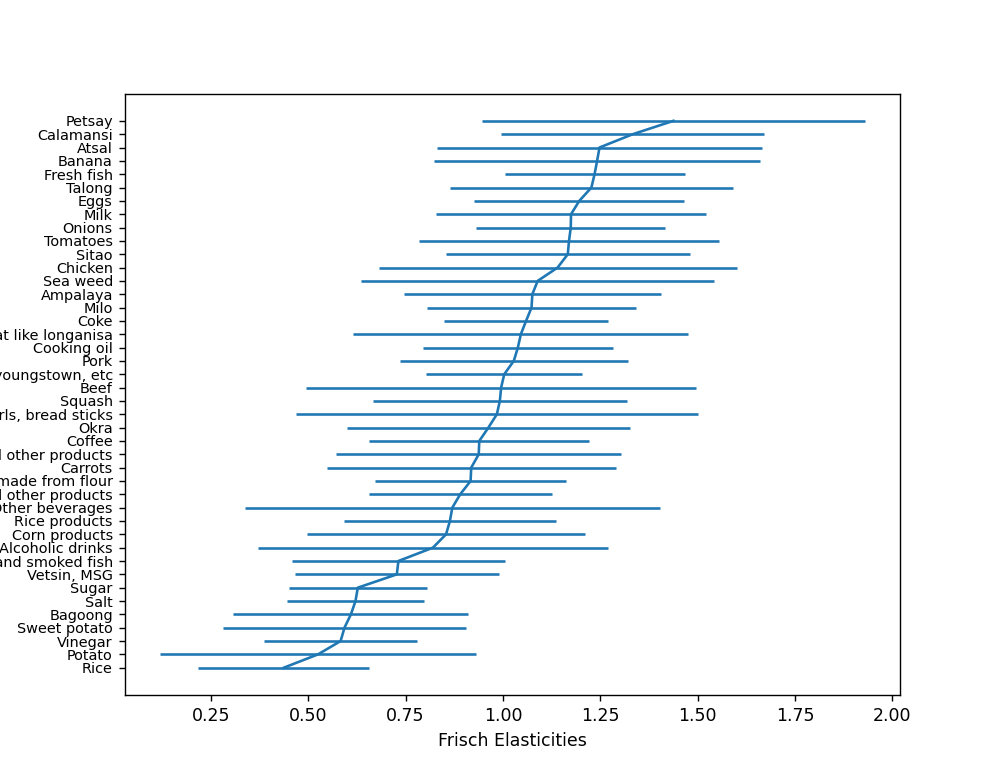

<IPython.core.display.Javascript object>


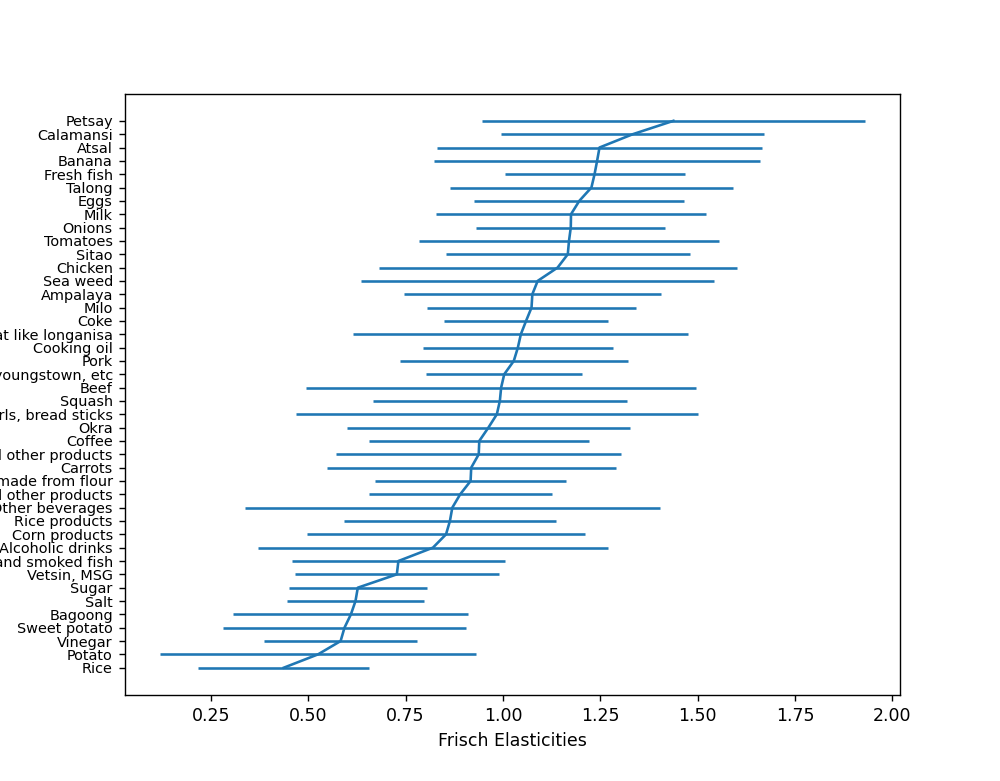

In [25]:
# elasticity of goods
beta = reg_result.get_beta().sort_values()
reg_result.graph_beta()

In [26]:
# demand for each age / sex group
reg_result.gamma

k,Males 0-1,Males 1-5,Males 5-10,Males 10-15,Males 15-20,Males 20-30,Males 30-50,Males 50-60,Males 60-100,Females 0-1,Females 1-5,Females 5-10,Females 10-15,Females 15-20,Females 20-30,Females 30-50,Females 50-60,Females 60-100,log HSize,Constant
j,,,,,,,,,,,,,,,,,,,,
Alcoholic drinks,0.167578,-0.009092,-0.050066,-0.194632,0.106636,0.217972,0.248910,-0.234048,-0.277192,-0.271023,-0.001309,-0.102215,0.094512,-0.075919,0.013904,0.003682,-0.010416,0.118566,-0.058963,-0.191506
Ampalaya,0.033300,0.368817,0.259375,0.255039,0.185829,0.239060,0.161268,0.089504,0.075035,-0.186582,0.148055,0.305813,0.187932,0.180529,0.129002,0.172812,0.174537,0.120056,-1.005324,0.367397
Atsal,0.076178,0.214911,0.312343,0.019122,0.112940,0.157415,0.094940,0.218926,0.032624,0.366526,-0.085272,0.338872,0.030293,-0.003056,0.142564,0.149496,0.054664,0.005785,-0.593274,0.123868
Bagoong,-0.084261,0.101493,0.091014,0.011673,0.064971,0.054927,0.057399,0.152972,0.144023,-0.289767,-0.024785,0.152063,0.048299,0.060973,-0.106980,0.016824,0.019041,-0.163483,0.295438,-0.740481
Banana,0.271568,0.218437,0.288330,0.240457,-0.064088,0.125584,-0.023391,0.084512,0.380285,-0.009375,0.069938,0.292862,0.044838,0.102656,0.052768,0.270173,0.261661,0.184777,-0.731487,0.303375
Beef,0.194938,0.039360,0.031371,0.114968,-0.066483,0.087062,0.147404,0.342633,0.009060,0.063315,0.006427,-0.003283,-0.022346,0.057225,0.007649,0.088129,-0.129808,-0.088884,-0.185411,-0.266420
Calamansi,-0.189225,-0.004375,0.139907,0.174533,0.132186,0.029016,-0.018518,-0.514148,0.009091,0.311062,0.135570,0.078610,0.226412,-0.079396,0.135957,0.190920,0.413739,0.102225,-0.300935,-0.110578
Carrots,0.145905,0.273372,-0.135994,-0.097526,-0.022060,-0.154796,-0.050761,-0.245145,0.111818,0.081189,-0.019716,-0.227082,-0.009596,0.181873,0.111162,0.362758,0.418212,-0.053574,-0.021670,-0.471097
Chicken,0.101307,0.080266,0.180819,-0.019252,0.007080,0.026569,0.017642,0.127111,-0.135140,-0.152778,-0.268606,0.161533,0.010589,0.021047,0.145233,-0.054448,-0.008045,0.156234,0.476183,-1.240715


In [28]:
# Estimates most things (not counting std errors for betas).
xhat = reg_result.get_predicted_log_expenditures() 

# xhat is an xarray; change to df
xhatdf = pd.DataFrame(xhat)
xhatdf.columns.name ='j'

q = quantities
q.columns.name = 'j'
q = q.groupby('j',axis=1).sum()
#print(x)
q = q.replace(0,np.nan) # Replace zeros with missing

print(xhatdf)
#phat = xhatdf/q

# Keep gram unit
#phat = phat.xs('g',level='u').groupby(['t','m']).median().T.dropna(how='all')
#result['prices'] = phat.stack().to_xarray().to_array()

# Make this persistent...
#result.to_dataset('./BUK.ds')

j                                          0
i   t    m        j                         
2   2003 Bukidnon Alcoholic drinks  2.488668
                  Ampalaya          1.837567
                  Atsal             2.172052
                  Bagoong           1.592421
                  Banana            2.967049
...                                      ...
941 2003 Bukidnon Sweet potato      2.076109
                  Talong            2.480614
                  Tomatoes          2.225446
                  Vetsin, MSG       1.820172
                  Vinegar           1.098985

[23898 rows x 1 columns]
